## Speech Emotion Recognition: 
### Data Preprocessing (EmoDB & RAVDESS)

Goals:
- Resample to fixed rate
- Convert to mono
- Trim silence / VAD
- Noise reduction
- Normalize amplitude
- Pad/truncate to duration
- Save cleaned files

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import noisereduce as nr
import librosa
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile as sf
import seaborn as sns
import matplotlib.patches as patches
from IPython.display import Audio
from pydub import AudioSegment
import librosa
import librosa.display
import matplotlib.pyplot as plt


c:\ADMIN FOLDERS\Sem-SU25\SERonEmoDB\emodbvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ADMIN FOLDERS\Sem-SU25\SERonEmoDB\emodbvenv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
from data_function import *

#### Load Dataset 

In [6]:
df_emoDB = load_dataset_emoDB(add_path = True, add_wave=True)

df_emoDB.head(3)

,label,wave,sample_rate,duration,channel,path
0,happy,"[0.0006713867, 0.0030822754, 0.002532959, 0.00...",16000,1.898250,mono,EmoDB\wav\03a01Fa.wav
1,neutral,"[0.0002746582, 9.1552734e-05, 0.00039672852, 0...",16000,1.611250,mono,EmoDB\wav\03a01Nc.wav
2,angry,"[0.0, 3.0517578e-05, -0.00015258789, -3.051757...",16000,1.877813,mono,EmoDB\wav\03a01Wa.wav


In [5]:
df_RAVDESS = load_dataset_RAVDESS(add_path=True, add_wave=True)

df_RAVDESS.head(3)

,label,wave,sample_rate,duration,channel,path
0,neutral,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,3.303292,mono,RAVDESS\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,"[0.0, 0.0, -3.0517578e-05, 0.0, 0.0, 0.0, 0.0,...",48000,3.336667,mono,RAVDESS\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,"[3.0517578e-05, 3.0517578e-05, 0.0, 3.0517578e...",48000,3.269917,mono,RAVDESS\Actor_01\03-01-01-01-02-01-01.wav


In [159]:
df_preprocessing =  pd.concat([df_emoDB, df_RAVDESS], ignore_index=True)

In [8]:
df_preprocessing.head()

,label,wave,sample_rate,duration,channel,path
0,happy,"[0.0006713867, 0.0030822754, 0.002532959, 0.00...",16000,1.898250,mono,EmoDB\wav\03a01Fa.wav
1,neutral,"[0.0002746582, 9.1552734e-05, 0.00039672852, 0...",16000,1.611250,mono,EmoDB\wav\03a01Nc.wav
2,angry,"[0.0, 3.0517578e-05, -0.00015258789, -3.051757...",16000,1.877813,mono,EmoDB\wav\03a01Wa.wav
3,happy,"[0.0007019043, 0.0025024414, 0.0026855469, -0....",16000,2.006250,mono,EmoDB\wav\03a02Fc.wav
4,neutral,"[6.1035156e-05, -0.00030517578, -0.00015258789...",16000,1.439812,mono,EmoDB\wav\03a02Nc.wav


#### **Preprocessing Data**

##### Resample Sampling Rate:   

EmoDB and RAVDESS have different `sampling_rate` (EmoDB: 16.000Hz, RAVDESS: 48.000Hz)   
&rarr; Imporve feature consistency and model input shape.

In [160]:
df_preprocessing.sample_rate.value_counts()

sample_rate
48000    1440
16000     535
Name: count, dtype: int64

In [161]:
def resample_audio(df, target_sr = 16000):
    for idx, row in df.iterrows():
        y = row['wave']
        sr = row['sample_rate']

        if sr != target_sr:
            try:
                y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
                df.at[idx, 'wave'] = y_resampled
                df.at[idx, 'sample_rate'] = target_sr
            except Exception as e:
                print(f"Error resampling at index {idx}: {e}")
    return df

In [162]:
df_preprocessing = resample_audio(df_preprocessing)

In [163]:
df_preprocessing.sample_rate.value_counts()

sample_rate
16000    1975
Name: count, dtype: int64

##### Convert to Mono:  
`Stereo audio` (2 channels) and the sound can give a sense of direction, while in `Mono audio` - the same sound goes to both your left and right ears. In SER problem, we are focusing on  the sound itself, not where it’s coming from.   
&rarr; Converting to Mono audio makes processing simpler, faster, and uses less memory.  

Note: All the data are already in mono shape

In [13]:
df_preprocessing.channel.value_counts()

channel
mono    1975
Name: count, dtype: int64

##### Trimming Silence:  
- Trimming silence at the beginning and the end of the audio files

    &rarr; Using `librosa.effects.trim` to trim the uneccessary silence 

- Moderate reduction of silence between speech  

    &rarr; *Voice Activity Detection (VAD)* is a technique used to detect whether a segment of audio contains speech or not by returning 1 (for speech) or 0 (for non-speech) for each short frame (typically 10-30 milliseconds).

    **Tool**: Using `webrtcvad` to remove silence within speech.  
    

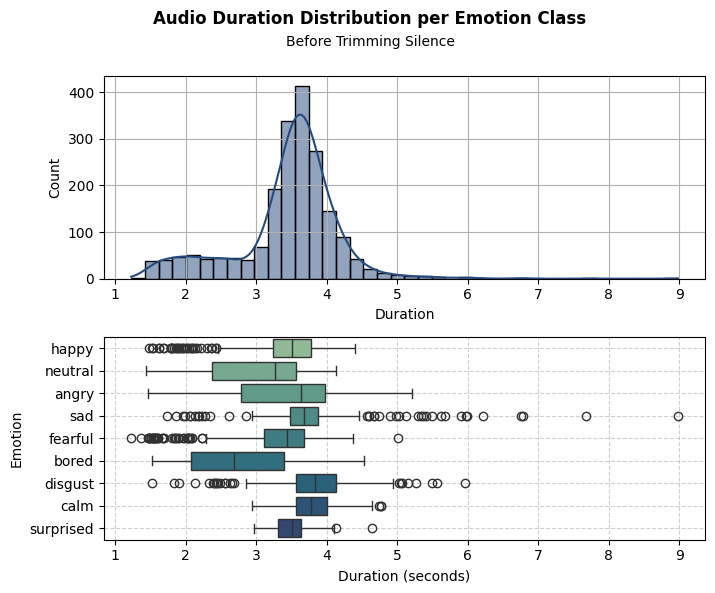

<Figure size 640x480 with 0 Axes>

In [164]:
draw_duration_distribution(df_preprocessing, source='Before Trimming Silence')

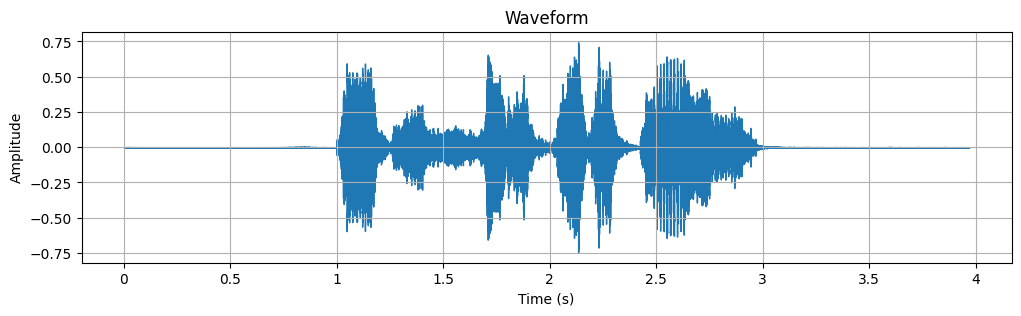

In [165]:
# Example of audio that have silence space at the opening and the end of the audio file

example_path_1 = r'RAVDESS\\Actor_09\\03-01-05-02-02-02-09.wav'

# example_path_1 = r'preprocessed_data\fearful\fearful_078.wav'
draw_single_waveform(path=example_path_1)


In [166]:
Audio(example_path_1)

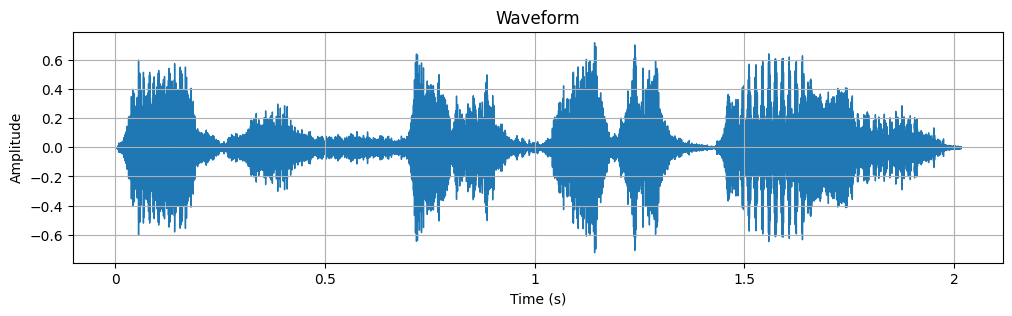

In [167]:
# After trimming the audio

y_example_1, _ = librosa.load(example_path_1, sr=16000, mono=True)

y_ex_1_trimmed, _ = librosa.effects.trim(y_example_1, top_db=20)

sf.write('EmoDB/test_trim_1.wav', y_ex_1_trimmed, 16000)

draw_single_waveform(path = 'EmoDB/test_trim_1.wav')

In [168]:
Audio("EmoDB/test_trim_1.wav")

In [169]:
def trim_sides_silences(df, top_db = 20):
    for idx, row in df.iterrows():
        y = row['wave']
        sr = row['sample_rate']
        try:
            y_trimmed_sides, _ = librosa.effects.trim(y, top_db=top_db)
            df.at[idx, 'wave'] = y_trimmed_sides
            df.at[idx, 'duration'] = librosa.get_duration(y=y_trimmed_sides, sr=sr)
        except Exception as e:
            print(f"Error resampling at index {idx}: {e}")
    return df

In [170]:
df_preprocessing = trim_sides_silences(df_preprocessing)

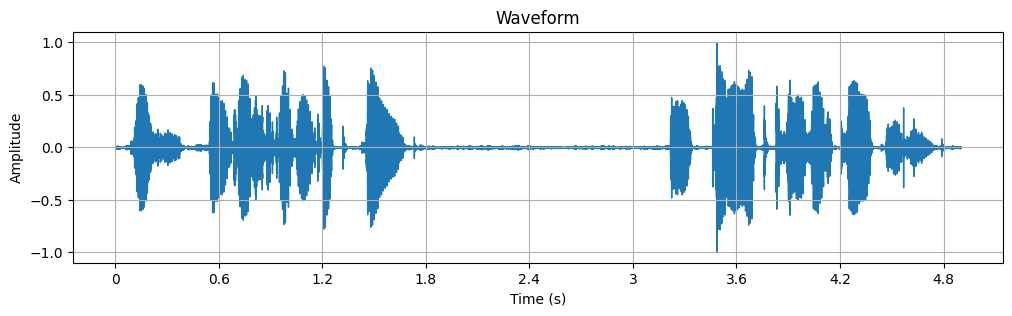

In [171]:
# Example of audio that have silence in between speech

example_path_2 = r"EmoDB\wav\11b09Td.wav"

draw_single_waveform(path = example_path_2)


In [172]:
Audio(example_path_2)

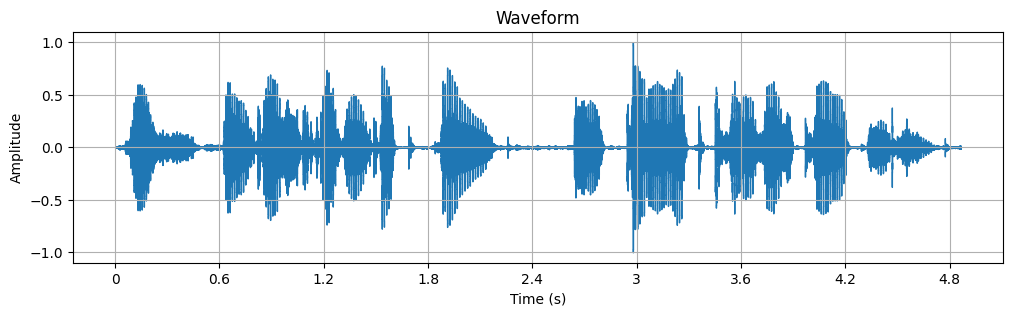

In [173]:
# remove silence within speech

y_example_2, _ = librosa.load(example_path_2)

intervals = librosa.effects.split(y_example_2, top_db=30)

y_ex_2_trimmed = np.concatenate([y_example_2[start:end] for start, end in intervals])

sf.write("EmoDB/test_trim_2.wav", y_ex_2_trimmed, samplerate=16000)

draw_single_waveform(path = "EmoDB/test_trim_2.wav")

In [174]:
Audio("EmoDB/test_trim_2.wav")

In [175]:
def trim_middle_silences(df, top_db = 30):
    for idx, row in df.iterrows():
        y = row['wave']
        sr = row['sample_rate']
        try:
            intervals = librosa.effects.split(y, top_db=top_db)
            y_trimmed_middle = np.concatenate([y[start:end] for start, end in intervals])
            df.at[idx, 'wave'] = y_trimmed_middle
            df.at[idx, 'duration'] = librosa.get_duration(y=y_trimmed_middle, sr=sr)
        except Exception as e:
            print(f"Error resampling at index {idx}: {e}")
    return df

In [176]:
df_preprocessing = trim_middle_silences(df_preprocessing, top_db=30)

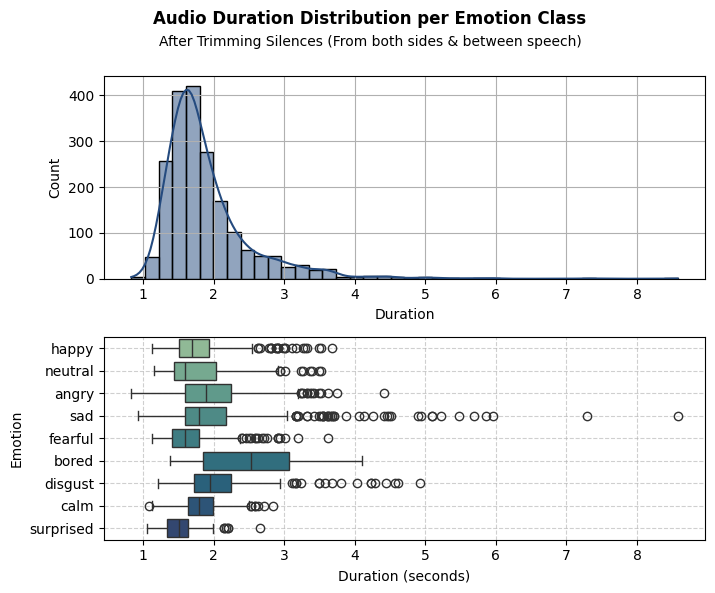

<Figure size 640x480 with 0 Axes>

In [177]:
draw_duration_distribution(df_preprocessing, source='After Trimming Silences (From both sides & between speech)')

##### Noise Reduction 

Minimize unwanted background sounds (noise) while preserving the desired signal. 

- Using `noisereduce` library - a simplified and optimized *spectral gating algorithm*

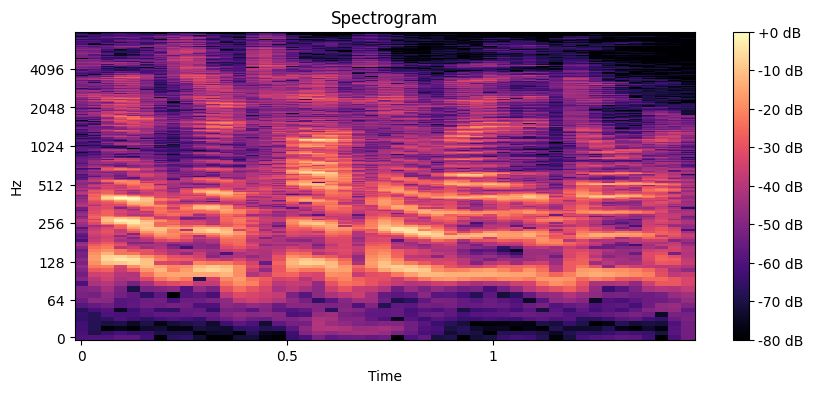

In [186]:
random.seed(45)

example_3 = random.randint(0, len(df_preprocessing)-1)

example_path_3 = df_preprocessing.at[example_3, 'path']
y_example_3 = df_preprocessing.at[example_3, 'wave']

draw_single_spectrogram(y = y_example_3)

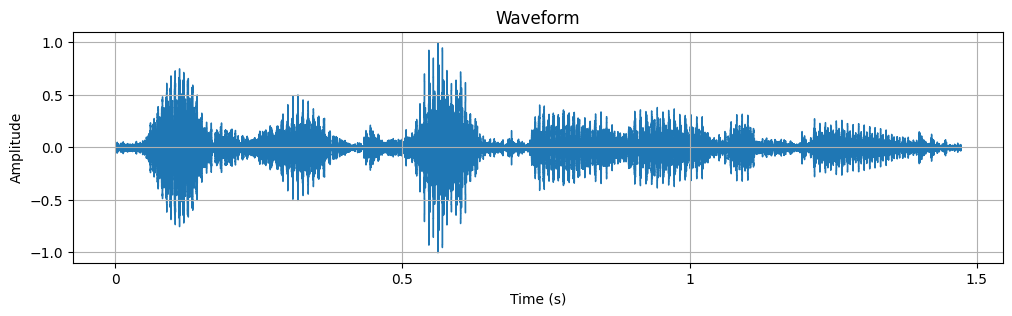

In [187]:
draw_single_waveform(y=y_example_3)

In [188]:
Audio(example_path_3)

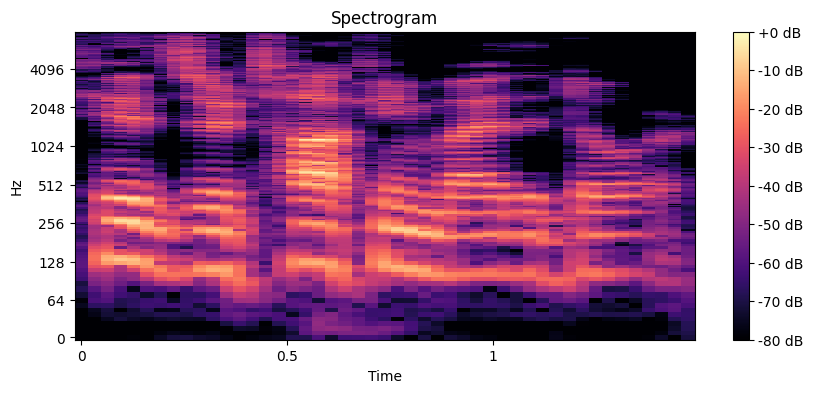

In [189]:
reduced = nr.reduce_noise(y=y_example_3, sr=16000)

sf.write('EmoDB/test_nr_3.wav', reduced, samplerate=16000)

draw_single_spectrogram(path='EmoDB/test_nr_3.wav')

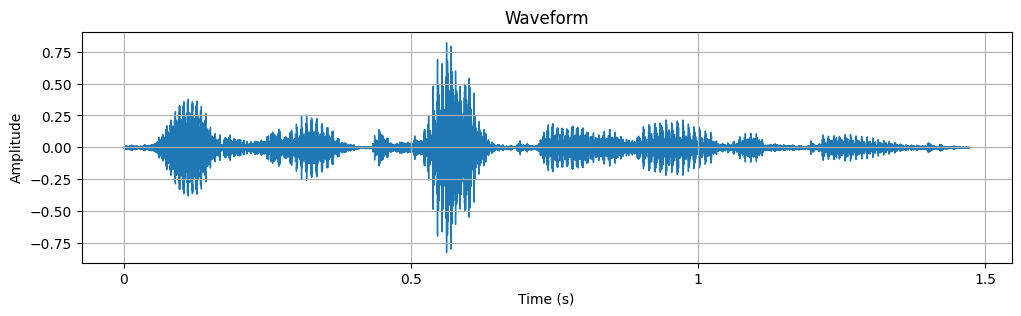

In [190]:
draw_single_waveform("EmoDB/test_nr_3.wav")

In [191]:
Audio("EmoDB/test_nr_3.wav")

In [192]:
def reduce_noise(df):
    for idx, row in df.iterrows():
        y = row['wave']
        sr = row['sample_rate']
        try:
            reduced = nr.reduce_noise(y=y, sr=sr)
            df.at[idx, 'wave'] = reduced
        except Exception as e:
            print(f"Error resampling at index {idx}: {e}")
    return df

In [193]:
df_preprocessing = reduce_noise(df_preprocessing)

##### Normalize Amplitude

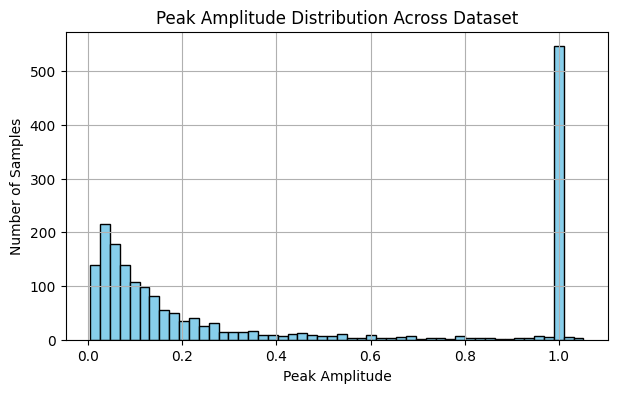

In [178]:
draw_peak_amplitude_distribution(df_preprocessing)

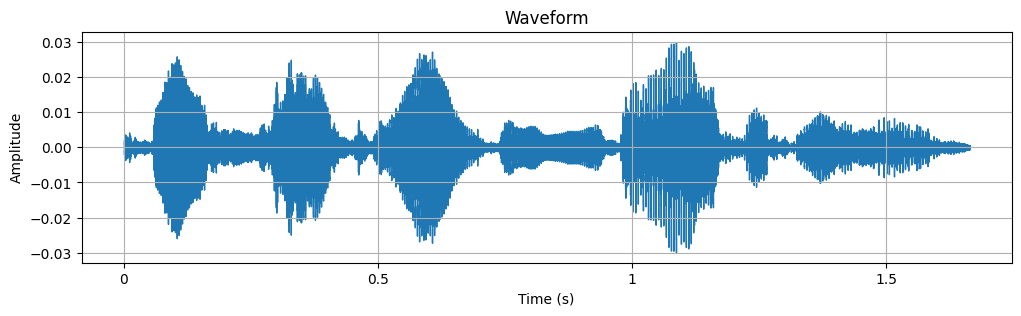

In [179]:
random.seed(44)

example_3 = random.randint(0, len(df_preprocessing)-1)

example_path_3 = df_preprocessing.at[example_3, 'path']
y_example_3 = df_preprocessing.at[example_3, 'wave']

draw_single_waveform(y = y_example_3)
Audio(example_path_3)

In [180]:
y_normalized = y_example_3 / np.max(np.abs(y_example_3)) if np.max(np.abs(y_example_3)) != 0 else y_example_3

sf.write("EmoDB/test_normalized_4.wav", y_normalized, samplerate=16000)

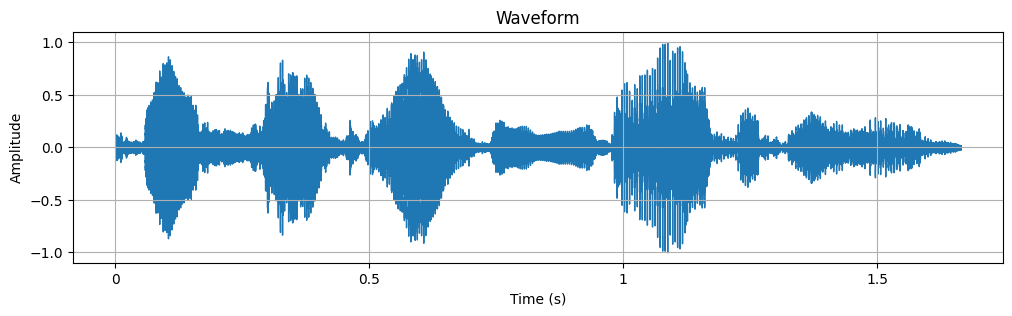

In [181]:
draw_single_waveform("EmoDB/test_normalized_4.wav")

Audio("EmoDB/test_normalized_4.wav")

In [182]:
def normalizing_amplitude(df):
    for idx, row in df.iterrows():
        y = row['wave']

        try:
            y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y
            df.at[idx, 'wave'] = y
        except Exception as e:
            print(f"Error resampling at index {idx}: {e}")
    return df

In [183]:
df_preprocessing = normalizing_amplitude(df_preprocessing)

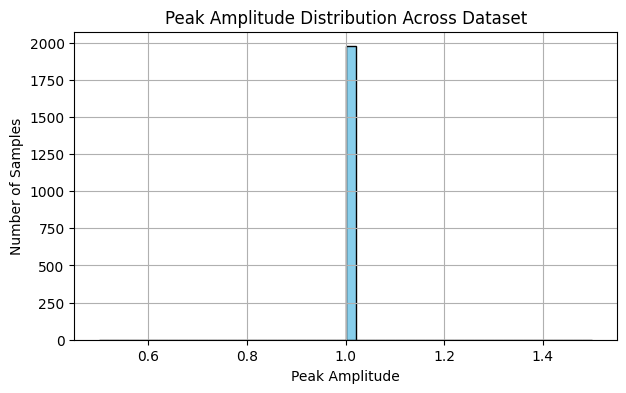

In [184]:
draw_peak_amplitude_distribution(df_preprocessing)

##### Pad/ Truncate Audio Duration

`target duration`: 3.0s  
`outliers threshold`: 4.0s

- for `duration` < `target duration`: padding both sides with 0
- for `duration` > `target duration` and < `outliers threshold` : truncate from both sides of waveform
- for `duration` > outliers threshold`:
    - divide the audio into 2 seperated audio  
    - process the audio again

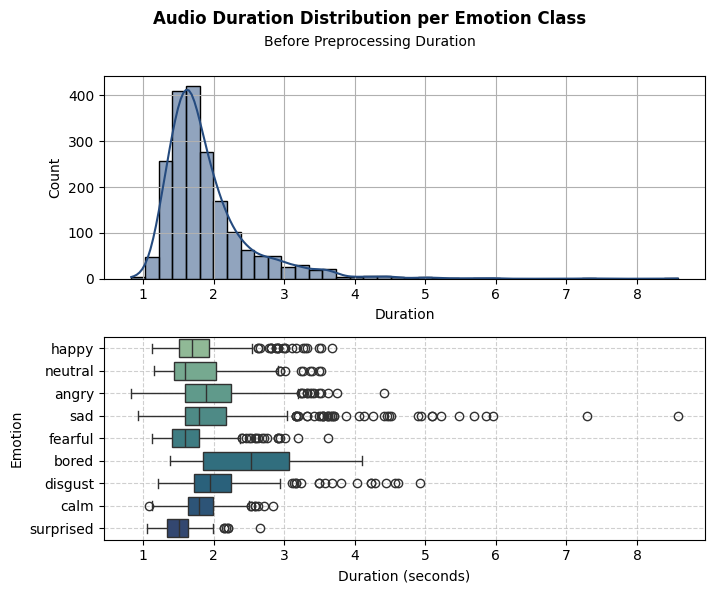

<Figure size 640x480 with 0 Axes>

In [194]:
draw_duration_distribution(df_preprocessing, source="Before Preprocessing Duration")

In [93]:
def outlier_processing(df, outlier_threshold = 4, sr=16000):
    """
    Split audio files longer than duration_threshold into two by the lowest amplitude point in the middle.
    Updated DataFrame with long files removed and replaced by their splits
    """
    df = df.copy()
    new_rows = []
    delete_path = []

    for idx, row in df.iterrows():
        path = row['path']
        y = row['wave']
        duration = row['duration']

        if duration <= outlier_threshold:
            continue

        # Find center segment and lowest amplitude
        center = len(y) // 2
        window = int(sr * 1.0)  # 2s window around center: 1s left + 1s right 
        start = max(center - window, 0)
        end = min(center + window, len(y))

        split_region = y[start:end]
        min_index = np.argmin(np.abs(split_region)) + start  # Offset by start

        # Split at the lowest amplitude
        y_a = y[:min_index]
        y_b = y[min_index:]

        # Create new file paths
        base, ext = os.path.splitext(path)
        path_a = f"{base}a{ext}"
        path_b = f"{base}b{ext}"

        # Save split audio files
        sf.write(path_a, y_a, sr)
        sf.write(path_b, y_b, sr)

        # Prepare new rows for DataFrame
        row_a = row.copy()
        row_b = row.copy()

        row_a['path'] = path_a
        row_a['label'] = row.label
        row_a['wave'] = y_a
        row_a['duration'] = len(y_a) / sr

        row_b['path'] = path_b
        row_b['label'] = row.label
        row_b['wave'] = y_b
        row_b['duration'] = len(y_b) / sr

        if 'label' in row:
            row_a['label'] = row['label']
            row_b['label'] = row['label']
        else:
            print(f"Missing label for: {path}")


        new_rows.extend([row_a, row_b])
        delete_path.append(path)

    # Drop old long rows
    df = df[~df['path'].isin(delete_path)]

    # Add new split rows
    new_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

    return new_df


In [195]:
df_preprocessing = outlier_processing(df_preprocessing)

In [197]:
def duration_processing(df, target_duration = 3):

    for idx, row in df.iterrows():
        y = row['wave']
        sr = row['sample_rate']

        target_length = int(sr * target_duration)
        current_length = len(y)

        if current_length == target_length:
            df.at[idx, 'wave'] = y
            df.at[idx, 'duration'] = current_length / sr

        elif current_length < target_length:
            # Padding needed
            pad_length = target_length - current_length
            pad_left = pad_length // 2
            pad_right = pad_length - pad_left
            y_padded = np.pad(y, (pad_left, pad_right), mode='constant')
            current_length = len(y_padded)
            df.at[idx, 'wave'] = y_padded
            df.at[idx, 'duration'] = current_length / sr

        elif current_length > target_length:
            # Truncation needed
            trim_length = current_length - target_length
            trim_left = trim_length // 2
            trim_right = trim_left + target_length
            y_trimmed = y[trim_left:trim_right]
            current_length = len(y_trimmed)
            df.at[idx, 'wave'] = y_trimmed
            df.at[idx, 'duration'] = current_length / sr

    return df


In [198]:
df_preprocessing = duration_processing(df_preprocessing)

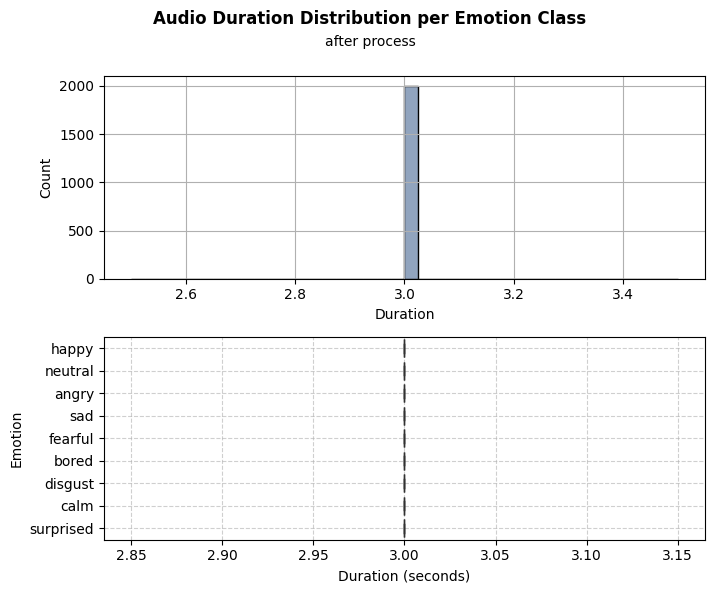

<Figure size 640x480 with 0 Axes>

In [199]:
draw_duration_distribution(df_preprocessing, 'after process')

In [200]:
copy_folders(df_preprocessing, output_base='final_preproccessed_data')

All files copied to final_preproccessed_data/
